# Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

from pandas.tseries.offsets import DateOffset

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

import warnings
warnings.filterwarnings("ignore")

# Dataset

In [2]:
# read dataset
df = pd.read_csv('confirmed_pivot.csv')
df.head()

,country,date,total
0,Afghanistan,2021-01-01,51526
1,Afghanistan,2021-01-10,53489
2,Afghanistan,2021-01-11,53538
3,Afghanistan,2021-01-12,53584
4,Afghanistan,2021-01-13,53584


In [3]:
# selecting datas only from Singapore
mask = df.loc[df['country'] == 'Singapore']
sg_dataset = pd.DataFrame(mask,columns=['date','total'])
sg_dataset.head()

,date,total
64480,2021-01-01,58629
64481,2021-01-10,58907
64482,2021-01-11,58929
64483,2021-01-12,58946
64484,2021-01-13,58984


In [4]:
# check for null values
sg_dataset.isna().sum()

date     0
total    0
dtype: int64

In [5]:
# convert date datatype to datetime
sg_dataset['date']=pd.to_datetime(sg_dataset['date'])
sg_dataset.dtypes

date     datetime64[ns]
total             int64
dtype: object

In [6]:
# set converting the dataset to monthly frequency
sg_dataset.set_index('date',inplace=True)
sg_dataset

,total
date,
2021-01-01,58629
2021-01-10,58907
2021-01-11,58929
2021-01-12,58946
2021-01-13,58984
...,...
2020-09-05,56982
2020-09-06,57022
2020-09-07,57044


In [7]:
sg_dataW = sg_dataset['total'].resample('W').interpolate().to_frame()
sg_dataW = sg_dataW.fillna(0)
print("Weekly:\n",sg_dataW)

sg_dataMS = sg_dataset['total'].resample('MS').interpolate().to_frame()
sg_dataMS = sg_dataMS.fillna(0)
print("Monthly:\n",sg_dataMS)

Weekly:
               total
date               
2020-01-26      4.0
2020-02-02     18.0
2020-02-09     40.0
2020-02-16     75.0
2020-02-23     89.0
2020-03-01    106.0
2020-03-08    150.0
2020-03-15    226.0
2020-03-22    455.0
2020-03-29    844.0
2020-04-05   1309.0
2020-04-12   2532.0
2020-04-19   6588.0
2020-04-26  13624.0
2020-05-03  18205.0
2020-05-10  23336.0
2020-05-17  28038.0
2020-05-24  31616.0
2020-05-31  34884.0
2020-06-07  37910.0
2020-06-14  40604.0
2020-06-21  42095.0
2020-06-28  43459.0
2020-07-05  44800.0
2020-07-12  45961.0
2020-07-19  47912.0
2020-07-26  50369.0
2020-08-02  52825.0
2020-08-09  55104.0
2020-08-16  55747.0
2020-08-23  56353.0
2020-08-30  56771.0
2020-09-06  57022.0
2020-09-13  57406.0
2020-09-20  57576.0
2020-09-27  57700.0
2020-10-04  57812.0
2020-10-11  57876.0
2020-10-18  57911.0
2020-10-25  57970.0
2020-11-01  58019.0
2020-11-08  58056.0
2020-11-15  58119.0
2020-11-22  58160.0
2020-11-29  58213.0
2020-12-06  58260.0
2020-12-13  58320.0
2020-12-20 

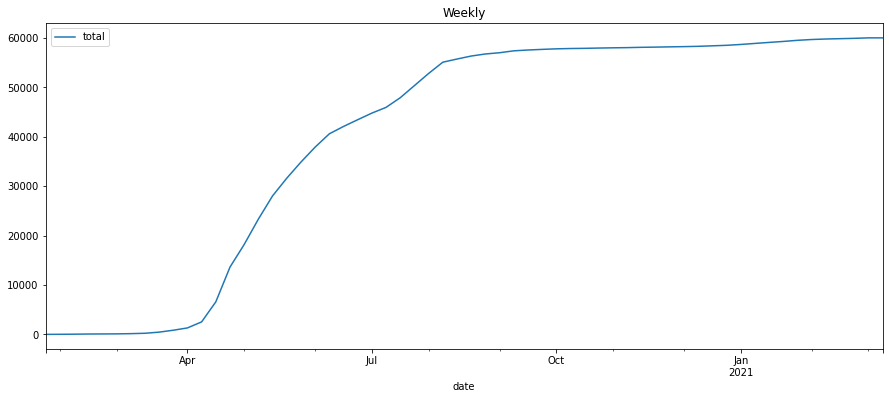

In [8]:
sg_dataW.plot(figsize=(15, 6))
plt.title("Weekly")
plt.show()

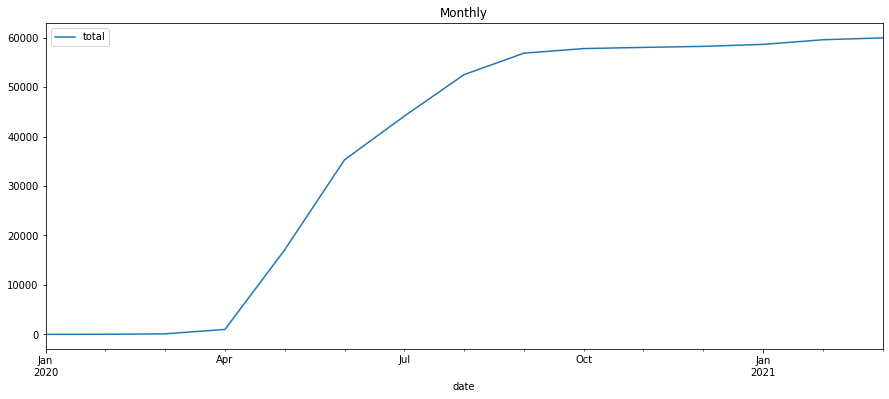

In [9]:
sg_dataMS.plot(figsize=(15, 6))
plt.title("Monthly")
plt.show()

# ARIMA

In [10]:
# function in order to determine if it is stationary or non stationary where Ho means non stationary and H1 means stationary

def adfuller_test(data):
    result=adfuller(data)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [11]:
adfuller_test(sg_dataW['total'])

ADF Test Statistic : -2.2490335264890495
p-value : 0.1889325591353696
#Lags Used : 1
Number of Observations Used : 58
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [12]:
adfuller_test(sg_dataMS['total'])

ADF Test Statistic : -2.102313279165488
p-value : 0.24358543832306678
#Lags Used : 5
Number of Observations Used : 9
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


# Differencing

To make our dataset stationary

In [13]:
sg_dataW['total first difference'] = sg_dataW['total'] - sg_dataW['total'].shift(6)
sg_dataW

,total,total first difference
date,,
2020-01-26,4.0,NaN
2020-02-02,18.0,NaN
2020-02-09,40.0,NaN
2020-02-16,75.0,NaN
2020-02-23,89.0,NaN
2020-03-01,106.0,NaN
2020-03-08,150.0,146.0
2020-03-15,226.0,208.0
2020-03-22,455.0,415.0


In [14]:
sg_dataMS['total first difference'] = sg_dataMS['total'] - sg_dataMS['total'].shift(2)
sg_dataMS

,total,total first difference
date,,
2020-01-01,0.0,NaN
2020-02-01,16.0,NaN
2020-03-01,106.0,106.0
2020-04-01,1000.0,984.0
2020-05-01,17101.0,16995.0
2020-06-01,35292.0,34292.0
2020-07-01,44122.0,27021.0
2020-08-01,52512.0,17220.0
2020-09-01,56852.0,12730.0


In [15]:
adfuller_test(sg_dataW['total first difference'].dropna())

ADF Test Statistic : -4.671025556585919
p-value : 9.535658751920748e-05
#Lags Used : 11
Number of Observations Used : 42
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [16]:
adfuller_test(sg_dataMS['total first difference'].dropna())

ADF Test Statistic : -8.79563917905743
p-value : 2.1803008741002437e-14
#Lags Used : 3
Number of Observations Used : 9
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


# Auto Regressive Model

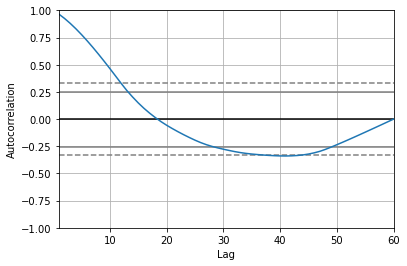

In [17]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(sg_dataW['total'])
plt.show()

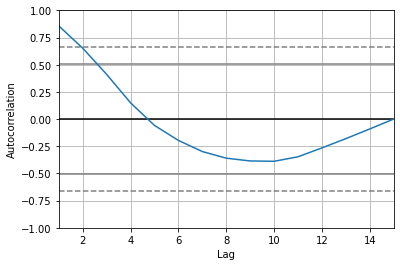

In [18]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(sg_dataMS['total'])
plt.show()

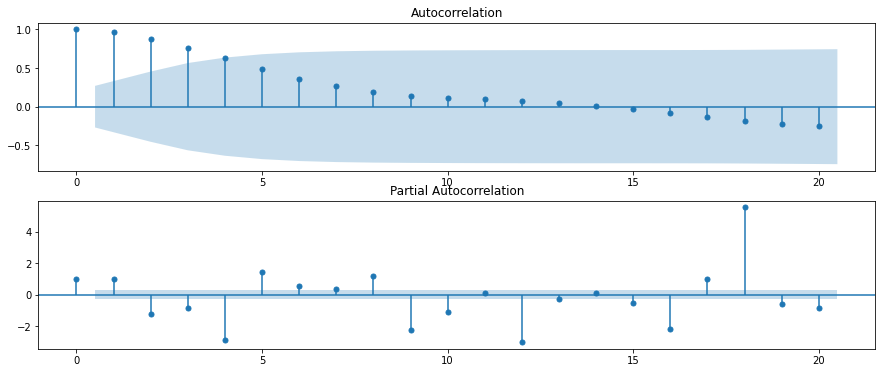

In [19]:
#Weekly
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sg_dataW['total first difference'].iloc[7:],lags=20,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sg_dataW['total first difference'].iloc[7:],lags=20,ax=ax2)

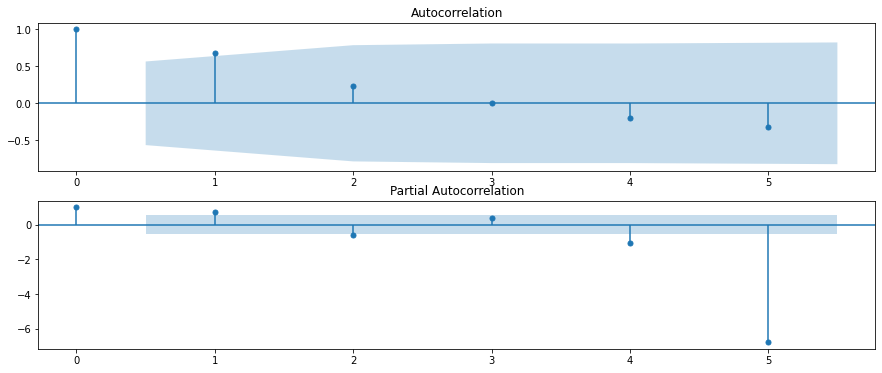

In [20]:
#Monthly
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sg_dataMS['total first difference'].iloc[3:],lags=5,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sg_dataMS['total first difference'].iloc[3:],lags=5,ax=ax2)

In [21]:
##p=1, d=0, q=0
w_model=ARIMA(sg_dataW['total'],order=(1,0,0))
w_model_fit=w_model.fit()
w_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  total   No. Observations:                   60
Model:                     ARMA(1, 0)   Log Likelihood                -540.765
Method:                       css-mle   S.D. of innovations           1873.097
Date:                Fri, 19 Mar 2021   AIC                           1087.531
Time:                        20:09:15   BIC                           1093.814
Sample:                    01-26-2020   HQIC                          1089.988
                         - 03-14-2021                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        8.521e+04        nan        nan        nan         nan         nan
ar.L1.total     0.9996        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0004           +0.0000j            1.0004            0.0000
-----------------------------------------------------------------------------
"""

In [22]:
##p=1, d=0, q=0
m_model=ARIMA(sg_dataMS['total'],order=(1,0,0))
m_model_fit=m_model.fit()
m_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  total   No. Observations:                   15
Model:                     ARMA(1, 0)   Log Likelihood                -156.124
Method:                       css-mle   S.D. of innovations           7321.662
Date:                Fri, 19 Mar 2021   AIC                            318.247
Time:                        20:09:15   BIC                            320.371
Sample:                    01-01-2020   HQIC                           318.225
                         - 03-01-2021                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3.173e+04   2.57e+04      1.235      0.217   -1.86e+04    8.21e+04
ar.L1.total     0.9665      0.042     22.985      0.000       0.884       1.049
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0346           +0.0000j            1.0346            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:xlabel='date'>

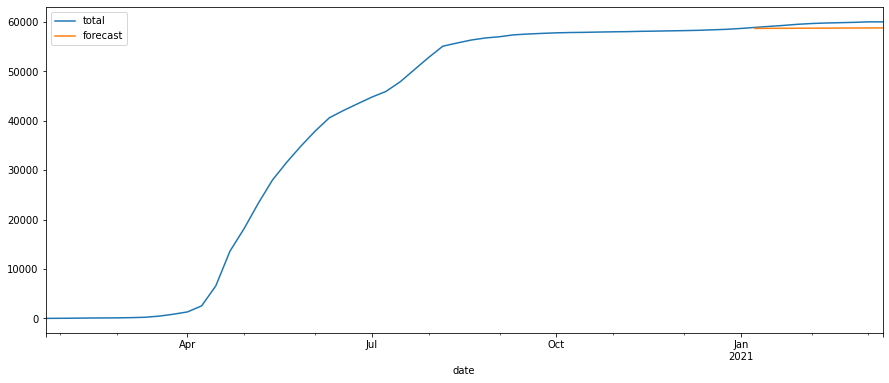

In [23]:
sg_dataW['forecast']=w_model_fit.predict(start=50,end=60,dynamic=True)
sg_dataW[['total','forecast']].plot(figsize=(15, 6))

<AxesSubplot:xlabel='date'>

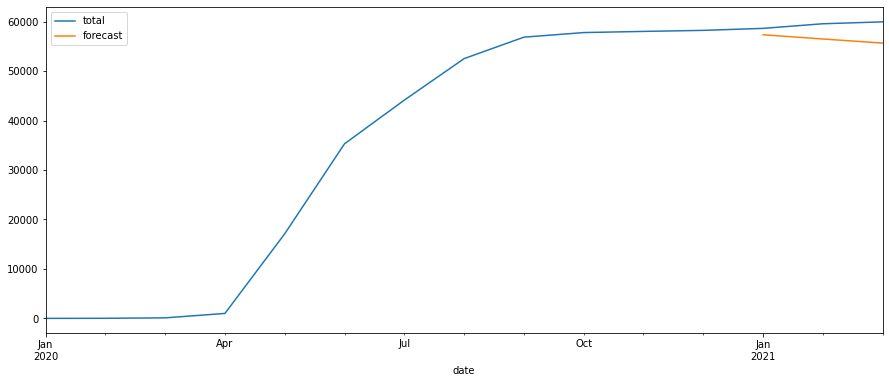

In [40]:
sg_dataMS['forecast']=m_model_fit.predict(start=12,end=15,dynamic=True)
sg_dataMS[['total','forecast']].plot(figsize=(15, 6))

# SARIMAX

In [25]:
import itertools

pW = dW = qW = range(0, 2)
pdqW = list(itertools.product(pW, dW, qW))
seasonal_pdqW = [(x[0], x[1], x[2], 30) for x in list(itertools.product(pW, dW, qW))]

pMS = dMS = qMS = range(0, 2)
pdqMS = list(itertools.product(pMS, dMS, qMS))
seasonal_pdqMS = [(x[0], x[1], x[2], 30) for x in list(itertools.product(pMS, dMS, qMS))]


In [26]:
yW = sg_dataset['total'].resample('W').mean()
yMS = sg_dataset['total'].resample('MS').mean()

print(yW,"\n\n",yMS)

date
2020-01-26        2.200000
2020-02-02       10.857143
2020-02-09       28.714286
2020-02-16       59.142857
2020-02-23       83.571429
2020-03-01       95.285714
2020-03-08      123.285714
2020-03-15      186.285714
2020-03-22      348.428571
2020-03-29      679.857143
2020-04-05     1066.571429
2020-04-12     1904.000000
2020-04-19     4560.857143
2020-04-26    10978.571429
2020-05-03    16291.142857
2020-05-10    20975.428571
2020-05-17    26031.714286
2020-05-24    29917.571429
2020-05-31    33362.571429
2020-06-07    36725.000000
2020-06-14    39401.857143
2020-06-21    41431.285714
2020-06-28    42823.428571
2020-07-05    44277.571429
2020-07-12    45457.428571
2020-07-19    47133.857143
2020-07-26    49134.714286
2020-08-02    51845.285714
2020-08-09    54290.857143
2020-08-16    55503.571429
2020-08-23    56105.857143
2020-08-30    56580.000000
2020-09-06    56912.000000
2020-09-13    57229.714286
2020-09-20    57523.571429
2020-09-27    57653.714286
2020-10-04    57773.142

In [27]:
for paramW in pdqW:
    for param_seasonalW in seasonal_pdqW:
        try:
            modW = sm.tsa.statespace.SARIMAX(yW,
                                            order=paramW,
                                            seasonal_order=param_seasonalW,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            resultsW = modW.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(paramW, param_seasonalW, resultsW.aic))
        except:
            continue

print("\n=====\n")

for paramMS in pdqMS:
    for param_seasonalMS in seasonal_pdqMS:
        try:
            modMS = sm.tsa.statespace.SARIMAX(yMS,
                                            order=paramMS,
                                            seasonal_order=param_seasonalMS,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            resultsMS = modMS.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(paramMS, param_seasonalMS, resultsMS.aic))
        except:
            continue            

ARIMA(0, 0, 0)x(0, 0, 0, 30)12 - AIC:1438.5748423258108
ARIMA(0, 0, 0)x(0, 0, 1, 30)12 - AIC:699.4590530639664
ARIMA(0, 0, 0)x(0, 1, 0, 30)12 - AIC:701.6324261775222
ARIMA(0, 0, 0)x(0, 1, 1, 30)12 - AIC:4.0
ARIMA(0, 0, 0)x(1, 0, 0, 30)12 - AIC:724.4894858342517
ARIMA(0, 0, 0)x(1, 0, 1, 30)12 - AIC:701.4590530499092
ARIMA(0, 0, 0)x(1, 1, 0, 30)12 - AIC:4.0
ARIMA(0, 0, 0)x(1, 1, 1, 30)12 - AIC:6.0
ARIMA(0, 0, 1)x(0, 0, 0, 30)12 - AIC:1375.2617693484754
ARIMA(0, 0, 1)x(0, 0, 1, 30)12 - AIC:665.6657457704464
ARIMA(0, 0, 1)x(0, 1, 0, 30)12 - AIC:654.8311660764274
ARIMA(0, 0, 1)x(0, 1, 1, 30)12 - AIC:6.0
ARIMA(0, 0, 1)x(1, 0, 0, 30)12 - AIC:713.1835474019307
ARIMA(0, 0, 1)x(1, 0, 1, 30)12 - AIC:667.6349375925713
ARIMA(0, 0, 1)x(1, 1, 0, 30)12 - AIC:6.0
ARIMA(0, 0, 1)x(1, 1, 1, 30)12 - AIC:8.0
ARIMA(0, 1, 0)x(0, 0, 0, 30)12 - AIC:1040.5036918302492
ARIMA(0, 1, 0)x(0, 0, 1, 30)12 - AIC:360.5741731230766
ARIMA(0, 1, 0)x(0, 1, 0, 30)12 - AIC:522.2187269846283
ARIMA(0, 1, 0)x(0, 1, 1, 30)12 - AIC

In [28]:
modelW=sm.tsa.statespace.SARIMAX(yW,order=(1, 1, 1),seasonal_order=(0,0,0,12), enforce_invertibility=False)
resultsW=modelW.fit()

print(resultsW.summary().tables[1])

modelMS=sm.tsa.statespace.SARIMAX(yMS,order=(1, 1, 1),seasonal_order=(0,0,0,12), enforce_invertibility=False)
resultsMS=modelMS.fit()

print(resultsMS.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8877      0.051     17.327      0.000       0.787       0.988
ma.L1          0.4092      0.098      4.161      0.000       0.216       0.602
sigma2       3.75e+05   2.77e+04     13.544      0.000    3.21e+05    4.29e+05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5500      0.198      2.781      0.005       0.162       0.938
ma.L1          1.9815      0.295      6.706      0.000       1.402       2.561
sigma2      5.126e+06   5.79e-08   8.85e+13      0.000    5.13e+06    5.13e+06


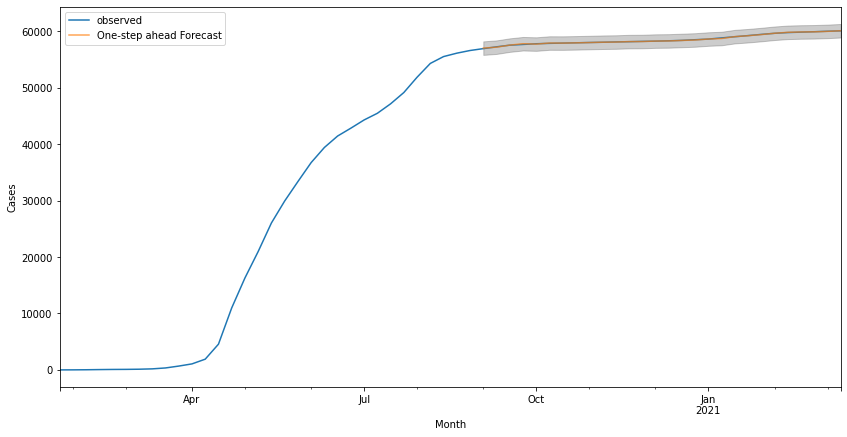

In [29]:
predW = resultsW.get_prediction(start=pd.to_datetime('2020-09-06'), dynamic=False)
pred_ci = predW.conf_int()
ax = yW['2020':].plot(label='observed')
predW.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Month')
ax.set_ylabel('Cases')
#plt.ylim(0, 40)
plt.legend()
plt.show()

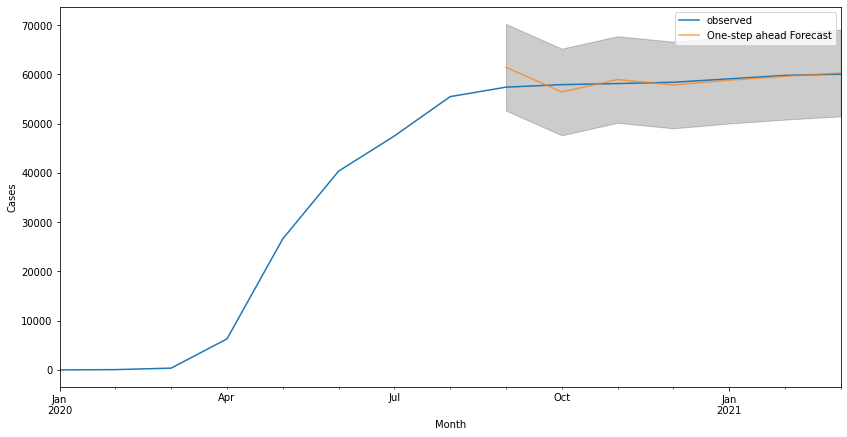

In [30]:
predMS = resultsMS.get_prediction(start=pd.to_datetime('2020-09-01'), dynamic=False)
pred_ci = predMS.conf_int()
ax = yMS['2020':].plot(label='observed')
predMS.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Month')
ax.set_ylabel('Cases')
#plt.ylim(0, 70000)
plt.legend()
plt.show()

# Future prediction

# Producing and visualizing forecasts

In [31]:
y_forecasted = predW.predicted_mean
y_truth = yW['2020-09-06':]
mseW = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts(WEEKLY) is {}'.format(round(mseW, 2)))

y_forecasted = predMS.predicted_mean
y_truth = yMS['2020-09-01':]
mseMS = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts(MONTHLY) is {}'.format(round(mseMS, 2)))

The Mean Squared Error of our forecasts(WEEKLY) is 1887.22
The Mean Squared Error of our forecasts(MONTHLY) is 2801812.18


In [32]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mseW), 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mseMS), 2)))

The Root Mean Squared Error of our forecasts is 43.44
The Root Mean Squared Error of our forecasts is 1673.86


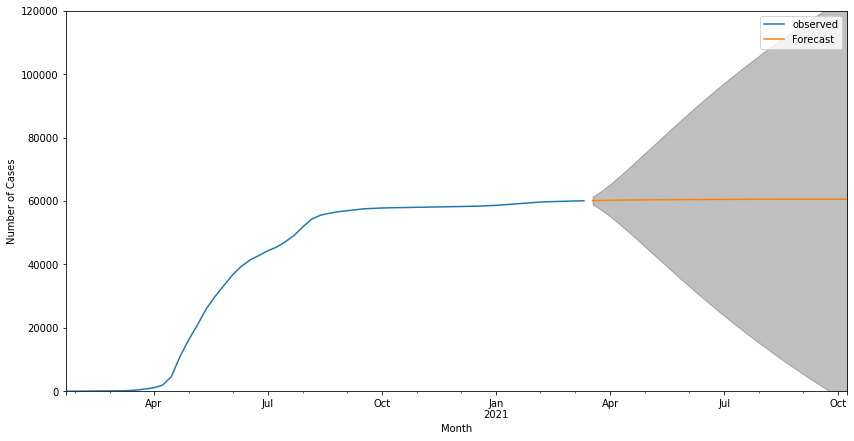

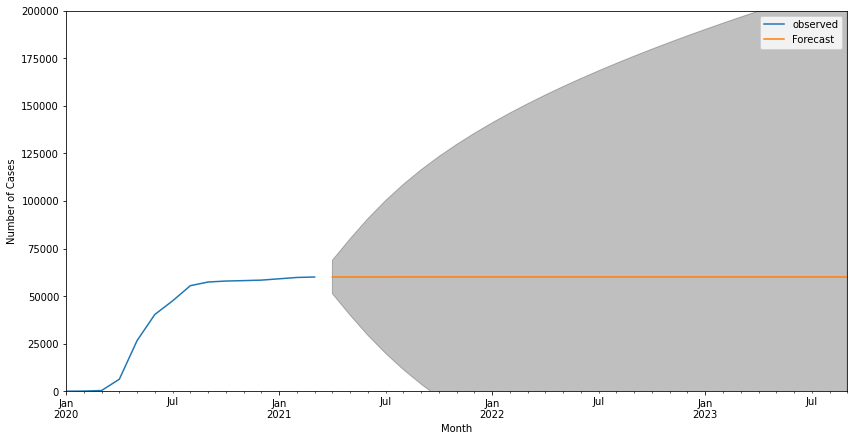

In [33]:
pred_uc = resultsW.get_forecast(steps=30)
pred_ci = pred_uc.conf_int()
ax = yW.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Month')
ax.set_ylabel('Number of Cases')
plt.ylim(0, 120000)
plt.legend()
plt.show()

pred_uc = resultsMS.get_forecast(steps=30)
pred_ci = pred_uc.conf_int()
ax = yMS.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Month')
ax.set_ylabel('Number of Cases')
plt.ylim(0, 200000)
plt.legend()
plt.show()